In [1]:
import numpy as np
import pandas as pd
import math
from google.colab import files, drive
from scipy.spatial.distance import directed_hausdorff
from scipy import stats
from scipy.special import expit
drive.mount('/content/drive')

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nfl-big-data-bowl-2024
!unzip nfl-big-data-bowl-2024.zip
!unzip /content/drive/MyDrive/weeks.zip

100% 278M/279M [00:09<00:00, 40.1MB/s]
100% 279M/279M [00:09<00:00, 31.0MB/s]
Archive:  nfl-big-data-bowl-2024.zip
  inflating: games.csv               
  inflating: players.csv             
  inflating: plays.csv               
  inflating: tackles.csv             
  inflating: tracking_week_1.csv     
  inflating: tracking_week_2.csv     
  inflating: tracking_week_3.csv     
  inflating: tracking_week_4.csv     
  inflating: tracking_week_5.csv     
  inflating: tracking_week_6.csv     
  inflating: tracking_week_7.csv     
  inflating: tracking_week_8.csv     
  inflating: tracking_week_9.csv     


In [3]:
# Initialize Data
players=pd.read_csv('players.csv')
# week1=pd.read_csv('tracking_week_1.csv')
# week2=pd.read_csv('tracking_week_2.csv')
# week3=pd.read_csv('tracking_week_3.csv')
# week4=pd.read_csv('tracking_week_4.csv')
# week5=pd.read_csv('tracking_week_5.csv')
# week6=pd.read_csv('tracking_week_6.csv')
# week7=pd.read_csv('tracking_week_7.csv')
# week8=pd.read_csv('tracking_week_8.csv')
# week9=pd.read_csv('tracking_week_9.csv')
games=pd.read_csv('games.csv')
plays=pd.read_csv('plays.csv')
tackles = pd.read_csv('tackles.csv')

In [9]:
week1 = pd.read_csv('week1.csv')
week2 = pd.read_csv('week2.csv')
week3 = pd.read_csv('week3.csv')
week4 = pd.read_csv('week4.csv')
week5 = pd.read_csv('week5.csv')
week6 = pd.read_csv('week6.csv')
week7 = pd.read_csv('week7.csv')
week8 = pd.read_csv('week8.csv')
week9 = pd.read_csv('week9.csv')
weeks = [week1, week2, week3, week4, week5, week6, week7, week8, week9]

In [87]:
data = pd.concat(weeks, axis=0, ignore_index=True)
tackles = tackles[(tackles.tackle==1) | (tackles.assist==1)]
df_defense = data[(data.club == data.defensiveTeam)].copy()
df_defense = df_defense.drop(columns=['prePenaltyPlayResult.1'])

In [110]:
def create_plays(df):
    metrics = ['individual_pressure_percentage', 'individual_pressure', 'generated_path_deviation']
    df = df.fillna(0)
    df['playDuration'] = df.end_frame - df.start_frame

    list_plays = []
    gameIds = list(df.gameId.unique())
    for gameId in gameIds:
        df_game = df[(df.gameId==gameId)]
        removeable = list(df_game[(df_game.event == 'fumble') | (df_game.event == 'touchdown')].playId.unique())
        playIds = list(df_game.playId.unique())
        playIds = [item for item in playIds if item not in removeable]
        for playId in playIds:
            df_play = df_game[(df_game.playId==playId)].copy()
            df_pre_play = df_play.loc[(df_play.frameId < df_play.start_frame)]
            df_in_play = df_play.loc[(df_play.frameId >= df_play.start_frame) & (df_play.frameId <= df_play.end_frame)]
            df_whole_play = df_play.loc[(df_play.frameId < df_play.end_frame)]
            for playerId in list(df_play.nflId.unique()):
                try:
                    dict_play = {'gameId': gameId, 'playId': playId, 'club': df_play.club.values[0], 'start_frame': df_play.start_frame.values[0], \
                            'end_frame': df_play.end_frame.values[0], 'playDuration': df_play.playDuration.values[0], \
                            'playResult': df_play.prePenaltyPlayResult.values[0]}
                    dict_play['displayName'] = df_in_play[df_in_play.nflId==playerId].displayName.values[0]
                    dict_play['nflId'] = playerId
                    dict_play['total_individual_pressure'] = df_in_play[df_in_play.nflId==playerId].individual_pressure.sum()
                    dict_play['total_generated_path_deviation'] = df_in_play[df_in_play.nflId==playerId].generated_path_deviation.sum()
                    dict_play['normalized_total_individual_pressure'] = dict_play['total_individual_pressure'] / dict_play['playDuration']
                    dict_play['normalized_total_generated_path_deviation'] = dict_play['total_generated_path_deviation'] / dict_play['playDuration']

                    dict_play['pre_pressure'] = df_pre_play.individual_pressure.sum()
                    dict_play['end_pressure'] = df_play[(df_play.nflId==playerId) & (df_play.frameId == df_play.end_frame)].individual_pressure.values[0]
                    dict_play['begin_pressure'] = df_play[(df_play.nflId==playerId) & (df_play.frameId == df_play.start_frame)].individual_pressure.values[0]
                    dict_play['peak_pressure'] = df_play.individual_pressure.max()
                    try:
                        dict_play['peak_pressure_frame'] = df_play[(df_play.nflId==playerId) & (dict_play['peak_pressure'] == df_play.individual_pressure)].frameId.values[0]
                    except:
                        dict_play['peak_pressure_frame'] = df_play.end_frame.values[0]

                    dict_play['ascent_duration'] = dict_play['peak_pressure_frame'] - dict_play['start_frame']
                    list_plays.append(dict_play)
                except:
                    continue
    return pd.DataFrame(list_plays)

def create_player_stats(df):
    value_counts = df['nflId'].value_counts()
    included_values = value_counts[value_counts >= 100].index.tolist()
    df = df[df['nflId'].isin(included_values)]
    list_stats = []
    playerIds = list(df.nflId.unique())
    for playerId in playerIds:
        stats = {}
        stats['playerId'] = playerId
        stats['displayName'] = df.loc[df.nflId==playerId].displayName.values[0]
        stats['club'] = df.loc[df.nflId==playerId].club.values[0]
        stats['individual_pressure_per_play'] = df.loc[df.nflId==playerId].total_individual_pressure.mean()
        stats['generated_path_deviation_per_play'] = df.loc[df.nflId==playerId].total_generated_path_deviation.mean()
        stats['normalized_total_individual_pressure_per_play'] = df.loc[df.nflId==playerId]['normalized_total_individual_pressure'].mean()
        stats['normalized_total_generated_path_deviation_per_play'] = df.loc[df.nflId==playerId]['normalized_total_generated_path_deviation'].mean()
        stats['tackles_and_assists'] = tackles[tackles.nflId==playerId].tackle.sum() + tackles[tackles.nflId==playerId].assist.sum()
        stats['synthetic_tackle'] = df.loc[df.nflId==playerId]['synthetic_tackle'].sum()
        stats['tackle_difference'] = stats['synthetic_tackle'] - stats['tackles_and_assists']
        list_stats.append(stats)
    return pd.DataFrame(list_stats)

def create_synthetic_tackles(df):
    gameIds = list(df.gameId.unique())
    for gameId in gameIds:
        df_game = df[(df.gameId==gameId)]
        playdIds = list(df_game.playId.unique())
        for playId in playdIds:
            df_play = df_game[(df_game.playId==playId)]
            if tackles[(tackles.gameId==gameId) & (tackles.playId==playId)].shape[0] == 2:
                tacklers = tackles[(tackles.gameId==gameId) & (tackles.playId==playId)].nflId.values.tolist()
                tackle_allocation = (1 - df_play.synthetic_tackle.sum())/2
                df.loc[(df.gameId==gameId) & (df.playId==playId) & (df.nflId==tacklers[0]), 'synthetic_tackle'] += tackle_allocation
                df.loc[(df.gameId==gameId) & (df.playId==playId) & (df.nflId==tacklers[1]), 'synthetic_tackle'] += tackle_allocation
            elif tackles[(tackles.gameId==gameId) & (tackles.playId==playId)].shape[0] == 1:
                tackler = tackles[(tackles.gameId==gameId) & (tackles.playId==playId)].nflId.values[0]
                tackle_allocation = 1 - df_play.synthetic_tackle.sum()
                df.loc[(df.gameId==gameId) & (df.playId==playId) & (df.nflId==tackler), 'synthetic_tackle'] += tackle_allocation
    return df

def tackle_weighting(path_deviation):
    tackle_weight = path_deviation / 150
    if tackle_weight > 1:
        tackle_weight = 1 + (tackle_weight - 1) * (0.6 / 0.5)
        if tackle_weight > 1.6:
            tackle_weight = 1.6
    return tackle_weight * 0.5

df_plays = create_plays(df_defense)
df_plays['synthetic_tackle'] = df_plays.total_generated_path_deviation.apply(tackle_weighting)
df_plays = create_synthetic_tackles(df_plays)
df_stats = create_player_stats(df_plays)

In [15]:
# Total Unique Plays Used
df_plays.playId.nunique()

3895

In [16]:
df_stats

,playerId,displayName,club,individual_pressure_per_play,generated_path_deviation_per_play,normalized_total_individual_pressure_per_play,normalized_total_generated_path_deviation_per_play
0,38577.0,Bobby Wagner,LA,5.853879,6.071252,0.199002,0.224261
1,41239.0,Aaron Donald,LA,3.794295,3.571072,0.128920,0.125099
2,42816.0,Troy Hill,LA,3.020335,3.505826,0.102234,0.167266
3,43294.0,Jalen Ramsey,LA,2.232916,3.554365,0.084989,0.183081
4,43298.0,Leonard Floyd,LA,4.365862,4.282258,0.138004,0.146253
...,...,...,...,...,...,...,...
480,43407.0,Juston Burris,CAR,3.493974,3.301094,0.123861,0.164300
481,46127.0,Isaiah Oliver,ATL,3.824289,6.038913,0.153925,0.274062
482,46278.0,Cornell Armstrong,ATL,2.448231,4.647264,0.120764,0.265717
483,54511.0,Josh Paschal,DET,2.246568,3.281685,0.083278,0.115582


In [19]:
# Top 10 Total Individual Pressure
df_stats.sort_values(by='individual_pressure_per_play', ascending=False)[['club','displayName','individual_pressure_per_play']].head(10)

,club,displayName,individual_pressure_per_play
195,MIA,Elandon Roberts,7.317294
137,CIN,Akeem Davis-Gaither,7.222198
118,CIN,Germaine Pratt,7.141851
9,LA,Ernest Jones,7.025872
456,ATL,Troy Andersen,6.865596
63,CAR,Damien Wilson,6.816908
472,DEN,Josey Jewell,6.727973
79,CLE,Jacob Phillips,6.707315
417,DEN,Alex Singleton,6.621393
232,NYJ,C.J. Mosley,6.616773


In [21]:
# Top 10 Total Generate Path Deviation
df_stats.sort_values(by='generated_path_deviation_per_play', ascending=False)[['club','displayName','generated_path_deviation_per_play']].head(10)

,club,displayName,generated_path_deviation_per_play
321,KC,Willie Gay,7.952909
417,DEN,Alex Singleton,7.418818
232,NYJ,C.J. Mosley,7.374187
363,GB,De'Vondre Campbell,7.371513
88,SF,Dre Greenlaw,7.332488
472,DEN,Josey Jewell,7.260618
137,CIN,Akeem Davis-Gaither,7.227890
375,MIN,Jordan Hicks,7.048648
446,MIA,Eric Rowe,7.033040
456,ATL,Troy Andersen,6.979660


In [27]:
# Top 10 Normalized Total Individual Pressure
df_stats.sort_values(by='normalized_total_individual_pressure_per_play', ascending=False)[['club','displayName','normalized_total_individual_pressure_per_play']].head(10)

,club,displayName,normalized_total_individual_pressure_per_play
137,CIN,Akeem Davis-Gaither,0.284571
472,DEN,Josey Jewell,0.273483
417,DEN,Alex Singleton,0.271070
456,ATL,Troy Andersen,0.265776
321,KC,Willie Gay,0.258587
118,CIN,Germaine Pratt,0.255302
195,MIA,Elandon Roberts,0.253364
205,MIA,Duke Riley,0.250336
9,LA,Ernest Jones,0.249667
275,TEN,Dylan Cole,0.246093


In [28]:
# Top 10 Normalized Total Generate Path Deviation
df_stats.sort_values(by='normalized_total_generated_path_deviation_per_play', ascending=False)[['club','displayName','normalized_total_generated_path_deviation_per_play']].head(10)

,club,displayName,normalized_total_generated_path_deviation_per_play
446,MIA,Eric Rowe,0.403022
468,TEN,Terrance Mitchell,0.382123
321,KC,Willie Gay,0.362402
417,DEN,Alex Singleton,0.347487
137,CIN,Akeem Davis-Gaither,0.345838
472,DEN,Josey Jewell,0.321380
251,BAL,Damarion Williams,0.318316
456,ATL,Troy Andersen,0.313685
145,PHI,Kyzir White,0.308736
205,MIA,Duke Riley,0.307528


In [33]:
# Teams Ranked by Total Pressure
df_stats.groupby(['club'])['individual_pressure_per_play'].sum().sort_values(ascending=False)

club
NE     66.981821
CAR    65.670217
MIA    63.997622
NO     63.380701
BAL    62.587072
ATL    62.379456
PIT    60.025747
LV     58.661727
WAS    58.485743
CIN    58.320805
HOU    58.227422
KC     57.758713
NYJ    57.659336
DEN    56.522665
NYG    56.421595
CHI    55.429701
TB     54.097704
GB     53.943965
CLE    53.240172
LAC    52.836887
SEA    52.346919
SF     51.839121
TEN    51.663697
PHI    51.370169
LA     51.226357
JAX    51.021983
BUF    50.844117
DAL    49.072342
IND    47.919798
ARI    47.141618
MIN    42.557955
DET    39.364483
Name: individual_pressure_per_play, dtype: float64

In [34]:
# Teams Ranked by Generated Path Deviation
df_stats.groupby(['club'])['generated_path_deviation_per_play'].sum().sort_values(ascending=False)

club
NO     78.124463
BAL    77.092947
NE     75.109954
CAR    71.953621
MIA    71.050186
ATL    69.645942
HOU    69.344834
SEA    68.934035
LV     68.931951
DEN    68.556469
PIT    68.010786
WAS    67.820394
NYJ    66.558986
CHI    65.372577
JAX    64.962629
NYG    64.691500
GB     63.969409
KC     63.351237
BUF    63.197952
PHI    62.985759
TEN    61.843524
DAL    61.059287
CIN    60.980072
IND    60.017157
CLE    59.292672
TB     59.090881
LAC    57.577103
ARI    57.336213
LA     54.476062
MIN    52.977589
SF     52.744480
DET    51.510436
Name: generated_path_deviation_per_play, dtype: float64

In [139]:
from sklearn.preprocessing import MinMaxScaler
df_team_normalized_pressure = pd.DataFrame(df_stats.groupby(['club'])['normalized_total_individual_pressure_per_play'].sum().sort_values(ascending=False))
df_team_normalized_path_deviation = pd.DataFrame(df_stats.groupby(['club'])['normalized_total_generated_path_deviation_per_play'].sum().sort_values(ascending=False))


scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_team_normalized_pressure = scaler.fit_transform(df_team_normalized_pressure)
df_team_normalized_pressure['scaled_team_normalized_pressure'] = scaled_team_normalized_pressure

scaled_team_normalized_path_deviation = scaler.fit_transform(df_team_normalized_path_deviation)
df_team_normalized_path_deviation['scaled_team_normalized_path_deviation'] = scaled_team_normalized_path_deviation

team_normalized_pressure_vs_path_deviation = pd.merge(df_team_normalized_pressure, df_team_normalized_path_deviation, on='club', how='inner')



team_normalized_pressure_vs_path_deviation.to_csv('teams_pressure_and_pd.csv', index=True)
files.download('teams_pressure_and_pd.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
import plotly.express as px

fig = px.scatter(x = team_normalized_pressure_vs_path_deviation['scaled_team_normalized_pressure'], y = team_normalized_pressure_vs_path_deviation['scaled_team_normalized_path_deviation'])
fig.add_hline(y=0, line_color="black", opacity=0.3)
fig.add_vline(x=0, line_color="black", opacity=0.3)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
    xaxis_title="Normalized Pressure",
    yaxis_title="Normalized Path Deviation",
)
z

In [133]:
df_plays[['total_generated_path_deviation', 'playResult']].median()
np.median(df_plays.groupby(['playId'])['total_generated_path_deviation'].sum().sort_values(ascending=False).values)

122.36246096499288

In [102]:
df_stats.sort_values(by='synthetic_tackle', ascending=False)[['club','displayName','synthetic_tackle','tackles_and_assists']].head(10)

,club,displayName,synthetic_tackle,tackles_and_assists
293,JAX,Foyesade Oluokun,63.720460,85
232,NYJ,C.J. Mosley,62.927924,87
434,SEA,Jordyn Brooks,60.186664,84
182,IND,Zaire Franklin,59.666303,83
95,CHI,Roquan Smith,57.756910,82
35,NO,Pete Werner,57.312900,73
375,MIN,Jordan Hicks,54.519538,74
42,ATL,Rashaan Evans,54.003473,84
323,KC,Nick Bolton,53.491821,69
150,PHI,T.J. Edwards,52.979767,74


In [106]:
df_stats.sort_values(by='tackles_and_assists', ascending=False)[['club','displayName','synthetic_tackle','tackles_and_assists']].head(10)

,club,displayName,synthetic_tackle,tackles_and_assists
232,NYJ,C.J. Mosley,62.927924,87
293,JAX,Foyesade Oluokun,63.720460,85
434,SEA,Jordyn Brooks,60.186664,84
42,ATL,Rashaan Evans,54.003473,84
182,IND,Zaire Franklin,59.666303,83
95,CHI,Roquan Smith,57.756910,82
375,MIN,Jordan Hicks,54.519538,74
150,PHI,T.J. Edwards,52.979767,74
338,LV,Divine Deablo,51.067992,73
35,NO,Pete Werner,57.312900,73


In [111]:
df_stats.sort_values(by='tackle_difference', ascending=False)[['club','displayName','synthetic_tackle','tackles_and_assists', 'tackle_difference']].head(10)

,club,displayName,synthetic_tackle,tackles_and_assists,tackle_difference
90,CHI,Robert Quinn,4.989293,4,0.989293
23,BUF,A.J. Epenesa,2.569974,2,0.569974
435,SEA,Darrell Taylor,8.815596,9,-0.184404
12,BUF,Von Miller,8.569342,9,-0.430658
106,SF,Kerry Hyder,4.555877,5,-0.444123
332,LV,Anthony Averett,12.406085,13,-0.593915
188,HOU,Kurt Hinish,6.361419,7,-0.638581
78,CLE,Tommy Togiai,5.281359,6,-0.718641
138,CIN,Cameron Sample,6.263140,7,-0.736860
474,BAL,Jason Pierre-Paul,5.173308,6,-0.826692


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_stats['synthetic_tackle'], shade=True)

plt.xlabel('Tackles + Assists')
plt.ylabel('Percentage of Players')
plt.title('Distribution of Redistributed Tackles')

plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df_stats['tackles_and_assists'], shade=True)

plt.xlabel('Tackles + Assists')
plt.ylabel('Percentage of Players')
plt.title('Distribution of Tackles and Assists')

plt.show()


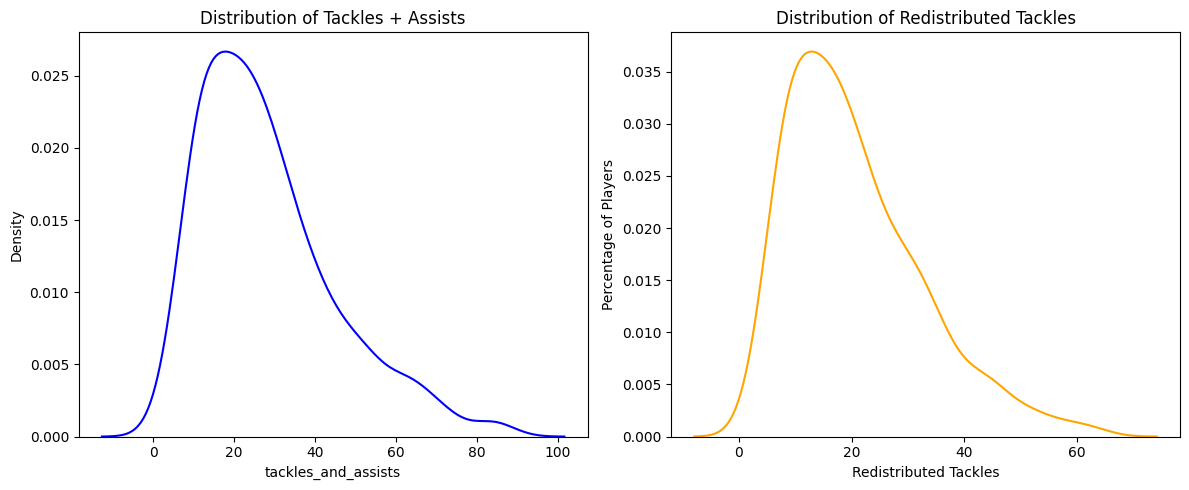

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.kdeplot(df_stats['tackles_and_assists'], ax=axes[0], color='blue', label='Tackles + Assists')
axes[0].set_title('Distribution of Tackles + Assists')
plt.xlabel('Tackles + Assists')
plt.ylabel('Percentage of Players')

sns.kdeplot(df_stats['synthetic_tackle'], ax=axes[1], color='orange', label='Redistributed Tackles')
axes[1].set_title('Distribution of Redistributed Tackles')
plt.xlabel('Redistributed Tackles')
plt.ylabel('Percentage of Players')

plt.tight_layout()
plt.show()

